In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import operator
import numpy as np

In [2]:
# Loading all results (with and without PorterStemer) and relevants
f_resultados = './NoStemmer/out/resultados_noStemmer.csv'
f_resultados_ps = './PorterStemmer/out/resultados_PorterStemmer.csv'
f_esperados = './NoStemmer/out/esperados_noStemmer.csv'

queries = {}  # without PorterStemer
for line in open(f_resultados, 'r'):
    if line.lower() != 'querynumber;[rank, document, similarity]\n':
        line = line.rstrip('\n')
        query = int(line.split(';')[0])
        result = line.split(';')[1].lstrip('[').rstrip(']')\
                 .replace(' ', '').split(',')
        if query not in queries:
            queries[query] = {}
        if int(result[1]) not in queries[query]:
            queries[query][int(result[1])] = float(result[2])

queries_ps = {}  # with PorterStemer
for line in open(f_resultados_ps, 'r'):
    if line.lower() != 'querynumber;[rank, document, similarity]\n':
        line = line.rstrip('\n')
        query = int(line.split(';')[0])
        result = line.split(';')[1].lstrip('[').rstrip(']')\
                 .replace(' ', '').split(',')
        if query not in queries_ps:
            queries_ps[query] = {}
        if int(result[1]) not in queries_ps[query]:
            queries_ps[query][int(result[1])] = float(result[2])

esperados = {}  # Relevants
for line in open(f_esperados, 'r'):
    if line.lower() != 'querynumber;docnumber;docvotes\n':
        line = line.rstrip('\n')
        if int(line.split(';')[0]) not in esperados:
            esperados[int(line.split(';')[0])] = {}
        if int(line.split(';')[1]) not in esperados[int(line.split(';')[0])]:
            esperados[int(line.split(';')[0])][int(line.split(';')[1])] = \
                int(line.split(';')[2])

In [3]:
def relevant(doc, esperados):
    if doc in esperados:
        return esperados[doc]
    else:
        return 0

def true_positive(a, b):
    """ Return quantity of TP - True Positives
        What is in A and B
        being A the set of Positive prediction
        and B the set of Actual Positive """

    tp = 0
    for item in a:
        if item in b:
            tp += 1
    return tp

def false_positive(a, b):
    """ Return quantity FP - False Positives
        What is in A and not in B
        being A the set of Positive prediction
        and B the set of Actual Positive """

    fp = 0
    for item in a:
        if item not in b:
            fp += 1
    return fp

def num_docs(a):
    """ Return a dict with all the documents returned in all
        queries """

    full_prediction_set = {}
    for item in a:
        for doc in a[item]:
            if doc not in full_prediction_set:
                full_prediction_set[doc] = 0
            full_prediction_set[doc] += 1
    return full_prediction_set

def true_negative(a, b, full_set):
    """ Return quantity TN - True Negative
            What is not in A and is not in B but is in full_set
            being A the set of Positive prediction
            B the set of Actual Positive
            and full_set the set of all documents in all search results """

    tn = 0
    neg = {}
    full_prediction_set = num_docs(full_set)
    for item in full_prediction_set:
        if item not in b:
            neg[item] = 1

    for item in neg:
        if item not in a:
            tn += 1
    return tn

def false_negative(a, b):
    """ Return quantity FN - False Negative
        What is not in A and is in B
        being A the set of Positive prediction
        and B the set of Actual Positive """

    fn = 0
    for item in b:
        if item not in a:
            fn += 1
    return fn

def get_recall(results, relevants, max_rank):
    count = 0
    considered_results = []
    for doc in results:
        count += 1
        if count <= max_rank:
            considered_results.append(doc)
        else:
            break

    # Evaluating Recall
    TP = true_positive(considered_results, relevants)
    recall = TP / len(relevants)

    return recall

def get_precision(results, relevants, max_rank):
    count = 0
    considered_results = []
    for doc in results:
        count += 1
        if count <= max_rank:
            considered_results.append(doc)
        else:
            break

    # Evaluating Precision
    TP = true_positive(considered_results, relevants)
    if len(considered_results) > 0:
        precision = TP / len(considered_results)
    else:
        precision = 0.0

    return precision

def interpolation(queries, recall_levels, esperados):
    """ Returns a dict({<Recall Level>: <Mean Precision>})
        with one precision value (mean) for each recall level
    """

    # Evaluate precision for each query within all recall levels
    precision = {}
    for level in range(0, len(recall_levels)):
        recall_level = recall_levels[level]
        precision[recall_level] = {}
        for query in queries:
            max_results = int(len(esperados[query]) * recall_level)
            precision[recall_level][query] = get_precision(queries[query],
                                                           esperados[query],
                                                           max_results)
            # count = 0
            # results = []
            # for doc in queries[query]:
            #     count += 1
            #     if count <= max_results:
            #         results.append(doc)
            #     else:
            #         break
            # TP = true_positive(results, esperados[query])
            # if len(results) > 0:
            #     precision[recall_level][query] = TP / len(results)
            # else:
            #     precision[recall_level][query] = 0
    # print(precision)

    # Convert all zero precision into the maximum precision on the greater
    # levels
    for query in queries:
        for level in range(0, len(recall_levels)):
            if precision[recall_levels[level]][query] == 0:
                for r in range(level, len(recall_levels)):
                    if precision[recall_levels[r]][query] > \
                       precision[recall_levels[level]][query]:
                        precision[recall_levels[level]][
                            query] = precision[recall_levels[r]][query]
    # print(precision)

    # Evaluate the mean of all query precisions of a given recall level
    avg_precision = {}
    for level in recall_levels:
        avg_precision[level] = 0
        for query in queries:
            avg_precision[level] += precision[level][query]
        avg_precision[level] /= len(queries)
    # print(avg_precision)

    return avg_precision

def precision_at(queries, esperados, rank):
    precision = {}
    for query in queries:
        precision[query] = get_precision(queries[query],
                                         esperados[query],
                                         rank)
    avg_precision = 0
    for query in queries:
        avg_precision += precision[query]
    avg_precision /= len(queries)
    return avg_precision

def f1score_at(queries, esperados, recall_level):
    f1 = {}
    for query in queries:
        max_rank = int(len(esperados[query]) * recall_level)
        precision = get_precision(queries[query], esperados[query], max_rank)
        recall = get_recall(queries[query], esperados[query], max_rank)
        # Evaluating F1-score
        if (precision + recall) > 0:
            f1[query] = 2 * (precision * recall) / (precision + recall)
        else:
            f1[query] = 0
    return f1

def avg(list):
    mean, count = 0, 0
    for i in list:
        count += 1
        mean += list[i]
    mean /= count
    return mean

# Mean Reciprocal Rank
def mrr(queries, esperados):
    ReciprocalRank = {}
    for query in queries:
        rank = 0
        results = []
        for doc in queries[query]:
            rank += 1
            if doc in esperados[query]:
                break
        ReciprocalRank[query] = 1 / rank
    mean_ReciprocalRank = 0
    for query in queries:
        mean_ReciprocalRank += ReciprocalRank[query]
    mean_ReciprocalRank /= len(queries)
    return mean_ReciprocalRank

# Cumulative Gain (CG)
def cg(queries, esperados):
    CumulativeGain = {}
    for query in queries:
        cc = 0
        rank = 0
        results = []
        for doc in queries[query]:
            rank += 1
            if doc in esperados[query]:
                cc += esperados[query][doc]
        CumulativeGain[query] = cc
    mean_CumulativeGain = 0
    for query in queries:
        mean_CumulativeGain += CumulativeGain[query]
    mean_CumulativeGain /= len(queries)
    return (mean_CumulativeGain, CumulativeGain)

# Discounted Cumulative Gain (DCG)
def dcg(queries, esperados):
    DiscountedCumulativeGain = {}
    for query in queries:
        dcg = 0
        rank = 0
        results = []
        for doc in queries[query]:
            rank += 1
            if doc in esperados[query]:
                dcg += esperados[query][doc] / (math.log2(rank + 1))
        DiscountedCumulativeGain[query] = dcg
    mean_DiscountedCumulativeGain = 0
    for query in queries:
        mean_DiscountedCumulativeGain += DiscountedCumulativeGain[query]
    mean_DiscountedCumulativeGain /= len(queries)
    return (mean_DiscountedCumulativeGain, DiscountedCumulativeGain)

# Alternative Discounted Cumulative Gain (aDCG)
def Alt_dcg(queries, esperados):
    DiscountedCumulativeGain = {}
    for query in queries:
        dcg = 0
        rank = 0
        results = []
        for doc in queries[query]:
            rank += 1
            if doc in esperados[query]:
                dcg += ((2 ^ esperados[query][doc])-1) / (math.log2(rank + 1))
        DiscountedCumulativeGain[query] = dcg
    mean_DiscountedCumulativeGain = 0
    for query in queries:
        mean_DiscountedCumulativeGain += DiscountedCumulativeGain[query]
    mean_DiscountedCumulativeGain /= len(queries)
    return (mean_DiscountedCumulativeGain, DiscountedCumulativeGain)

# Normalized Alternative Discounted Cumulative Gain (nDCG)
def nAlt_dcg(queries, esperados):
    nDiscountedCumulativeGain = {}
    for query in queries:
        idcg = 0
        esperados_sorted = sorted(esperados[query].items(),
                                  key = operator.itemgetter(1),
                                  reverse = True)
        for i in range(0, len(esperados_sorted)):
            rank = i + 1
            idcg += ((2 ^ esperados_sorted[i][1])-1) / (math.log2(rank + 1))
        dcg = 0
        rank = 0
        for doc in queries[query]:
            rank += 1
            if doc in esperados[query]:
                dcg += ((2 ^ esperados[query][doc])-1) / (math.log2(rank + 1))
        nDiscountedCumulativeGain[query] = dcg / idcg
    mean_nDiscountedCumulativeGain = 0
    for query in queries:
        mean_nDiscountedCumulativeGain += nDiscountedCumulativeGain[query]
    mean_nDiscountedCumulativeGain /= len(queries)
    return (mean_nDiscountedCumulativeGain, nDiscountedCumulativeGain)

# bpref
def bpref_measure(queries, esperados):
    """
    :param queries: list of list containing ranked returned documents by query
    :param esperados: list of list containing relevant documents by query
    :return: list of bpref value for each query

    Implements:
    bpref = (1/R) * sum(1 - |n ranked higher than r|/R)
    """
    bpref = {}
    for query in queries:
        R = len(esperados[query]) # the number of judged relevant documents
        N = 0 # the count of irrelevants until one relevant
        S = 0 # the sum of (1 - count/min(R, N))
        for doc in esperados[query]:
            if doc in queries[query]:
                S += (1 - N / R)
            else:
                N += 1
        bpref[query] = S / R
    return bpref

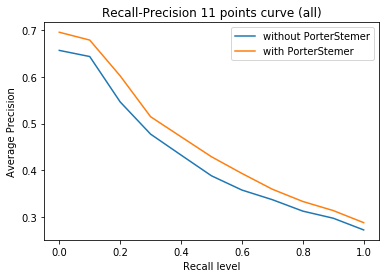

In [4]:
# Gráfico de precisão em 11 níveis de revocação
# recall_levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
#                  0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
recall_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
noStemmerRP = interpolation(queries, recall_levels, esperados)
PorterStemmerRP = interpolation(queries_ps, recall_levels, esperados)
plt.figure(1)
plt.plot(*zip(*sorted(noStemmerRP.items())), label = 'without PorterStemer')
plt.plot(*zip(*sorted(PorterStemmerRP.items())), label = 'with PorterStemer')
plt.xlabel('Recall level')
plt.ylabel('Average Precision')
plt.title('Recall-Precision 11 points curve (all)')
plt.legend(loc = 'best')
plt.show()

F1-score @ 70% recall without PorterStemer: 0.2702282188525496
F1-score @ 70% recall with PorterStemer: 0.2884605139407687


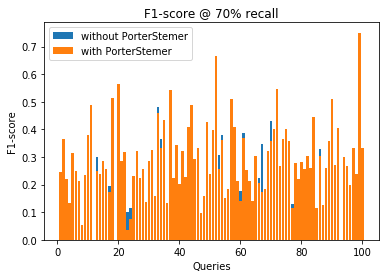

In [5]:
# F1-Score
noStemmerF1 = f1score_at(queries, esperados, 0.7)
PorterStemmerF1 = f1score_at(queries_ps, esperados, 0.7)
print('F1-score @ 70% recall without PorterStemer: ' +
      str(avg(noStemmerF1)))
print('F1-score @ 70% recall with PorterStemer: ' +
      str(avg(PorterStemmerF1)))
plt.figure(2)
plt.bar(*zip(*sorted(noStemmerF1.items())), label = 'without PorterStemer')
plt.bar(*zip(*sorted(PorterStemmerF1.items())), label = 'with PorterStemer')
plt.xlabel('Queries')
plt.ylabel('F1-score')
plt.title('F1-score @ 70% recall')
plt.legend(loc = 'best')
plt.show()

In [6]:
# MAP - Mean Average Precision
noStemmerMAP = avg(noStemmerRP)
PorterStemmerMAP = avg(PorterStemmerRP)
print('MAP without PorterStemer: ' + str(noStemmerMAP))
print('MAP with PorterStemer: ' + str(PorterStemmerMAP))

MAP without PorterStemer: 0.42931477142978786
MAP with PorterStemer: 0.4617735407057358


In [7]:
# P@5 & P@10
noStemmerP_at_5 = precision_at(queries, esperados, 5)
print('Precision @ 5 without PorterStemer: ' + str(noStemmerP_at_5))
noStemmerP_at_10 = precision_at(queries, esperados, 10)
print('Precision @ 10 without PorterStemer: ' + str(noStemmerP_at_10))
PorterStemmer_at_5 = precision_at(queries_ps, esperados, 5)
print('Precision @ 5 with PorterStemer: ' + str(PorterStemmer_at_5))
PorterStemmer_at_10 = precision_at(queries_ps, esperados, 10)
print('Precision @ 10 with PorterStemer: ' + str(PorterStemmer_at_10))

Precision @ 5 without PorterStemer: 0.501010101010101
Precision @ 10 without PorterStemer: 0.417171717171717
Precision @ 5 with PorterStemer: 0.5575757575757576
Precision @ 10 with PorterStemer: 0.4545454545454544


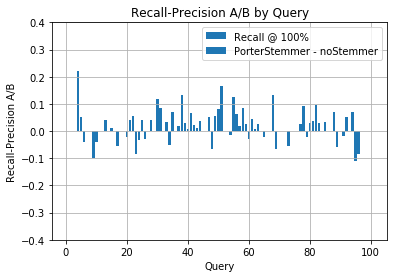

In [8]:
# Gráfico RPA/B
RP_AB = {}
for query in queries:
    max_rank = len(esperados[query])
    noStemmerP = get_precision(queries[query], esperados[query], max_rank)
    PorterStemmerP = get_precision(queries_ps[query], esperados[query],
                                   max_rank)
    RP_AB[query] = PorterStemmerP - noStemmerP
plt.figure(3)
plt.gca().yaxis.grid()
plt.gca().xaxis.grid()
rect = plt.bar(*zip(*sorted(RP_AB.items())), align='center')
plt.yticks(np.arange(-0.4, 0.5, 0.1))
plt.xlabel('Query')
plt.ylabel('Recall-Precision A/B')
plt.title('Recall-Precision A/B by Query')
a_patch = mpatches.Patch(label='Recall @ 100%')
b_patch = mpatches.Patch(label='PorterStemmer - noStemmer')
plt.legend(handles=[a_patch, b_patch], loc = 'best')
# plt.legend(loc = 'best')
plt.show()

In [9]:
# MRR - Mean Reciprocal Rank
noStemmerMRR = mrr(queries, esperados)
print('MRR without Porter Stemmer: ' + str(noStemmerMRR))
PorterStemmerMRR = mrr(queries_ps, esperados)
print('MRR with Porter Stemmer: ' + str(PorterStemmerMRR))

MRR without Porter Stemmer: 0.7660532258571474
MRR with Porter Stemmer: 0.791447051973368


Mean Normalized Discounted Cumulative Gain without PorterStemmer = 0.5995801636512855
Mean Normalized Discounted Cumulative Gain with PorterStemmer = 0.618253827874451


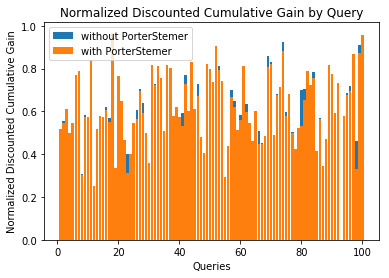

In [10]:
# Normalized DCG - Discounted Cumulative Gain
noPorter_nDCG = nAlt_dcg(queries, esperados)
print('Mean Normalized Discounted Cumulative Gain without PorterStemmer = ' +
      str(noPorter_nDCG[0]))

PorterStemmer_nDCG = nAlt_dcg(queries_ps, esperados)
print('Mean Normalized Discounted Cumulative Gain with PorterStemmer = ' +
      str(PorterStemmer_nDCG[0]))

plt.figure(4)
plt.bar(*zip(*sorted(noPorter_nDCG[1].items())),
        label = 'without PorterStemer')
plt.bar(*zip(*sorted(PorterStemmer_nDCG[1].items())),
        label = 'with PorterStemer')
plt.xlabel('Queries')
plt.ylabel('Normalized Discounted Cumulative Gain')
plt.title('Normalized Discounted Cumulative Gain by Query')
plt.legend(loc = 'best')
plt.show()

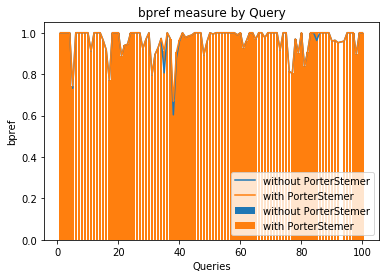

In [11]:
# bpref
noStemmer_bpref = bpref_measure(queries, esperados)
PorterStemmer_bpref = bpref_measure(queries_ps, esperados)
plt.figure(5)
plt.bar(*zip(*sorted(noStemmer_bpref.items())),
        label = 'without PorterStemer')
plt.bar(*zip(*sorted(PorterStemmer_bpref.items())),
        label = 'with PorterStemer')
plt.plot(*zip(*sorted(noStemmer_bpref.items())),
        label = 'without PorterStemer')
plt.plot(*zip(*sorted(PorterStemmer_bpref.items())),
        label = 'with PorterStemer')
plt.xlabel('Queries')
plt.ylabel('bpref')
plt.title('bpref measure by Query')
plt.legend(loc = 'best')
plt.show()